In [ ]:
import pandas as pd
import numpy as np
import re
import os
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import time
import matplotlib.pyplot as plt
import seaborn as sns
# Set plot style
sns.set(style="whitegrid")
from wordcloud import WordCloud
import itertools
import io
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
true_news = pd.read_csv('/content/drive/MyDrive/data/Hindi_Fake_news_data/authentic.csv')

print(true_news)

      Unnamed: 0                                                URL  \
0              0  https://hindi.oneindia.com/news/india/when-aam...   
1              1  https://hindi.oneindia.com/news/india/ec-suspe...   
2              2  https://hindi.oneindia.com/news/india/assam-yo...   
3              3  https://hindi.oneindia.com/news/india/tamil-na...   
4              4  https://hindi.oneindia.com/news/india/aamir-kh...   
...          ...                                                ...   
6152        6152  https://www.bhaskar.com/international/news/6-p...   
6153        6153  https://www.bhaskar.com/career/news/fci-sarkar...   
6154        6154  https://www.bhaskar.com/local/uttar-pradesh/al...   
6155        6155  https://www.bhaskar.com/career/news/dmw-sarkar...   
6156        6156  https://www.bhaskar.com/business/news/loan-hom...   

                                                  Title  \
0     जब जूही चावला से आमिर खान ने 7 सालों तक नहीं क...   
1     नंदीग्राम हमले पर चुनाव

In [ ]:
fake_news =pd.read_csv('/content/drive/MyDrive/data/Hindi_Fake_news_data/fake.csv')
print(fake_news)

      Unnamed: 0                                                URL  \
0              0  https://hindi.boomlive.in/fact-check/go-back-m...   
1              1  https://hindi.boomlive.in/fact-check/-kisan-an...   
2              2  https://hindi.boomlive.in/fact-check/delhi-hig...   
3              3  https://hindi.boomlive.in/fact-check/uttar-pra...   
4              4  https://hindi.boomlive.in/fact-check/undertake...   
...          ...                                                ...   
6482        2994  https://www.vishvasnews.com/politics/fact-chec...   
6483        2995  https://www.vishvasnews.com/viral/fact-check-n...   
6484        2996  https://www.vishvasnews.com/viral/fact-check-v...   
6485        2997  https://www.vishvasnews.com/health/fact-check-...   
6486        2998  https://www.vishvasnews.com/politics/fact-chec...   

                                                  Title  \
0     रोड पर 'गो बैक मोदी' का नारा दिखाती यह फ़ोटो तम...   
1     किसान आंदोलन: कीलों के 

In [ ]:
true_news = true_news.drop("dates", axis='columns')

In [ ]:
fake_news = fake_news.drop("dates", axis='columns')

In [ ]:
# Try dropping columns that start with 'Unnamed'
true_news = true_news.loc[:, ~true_news.columns.str.startswith('Unnamed')]
print( true_news.tail())

                                                    URL  \
6152  https://www.bhaskar.com/international/news/6-p...   
6153  https://www.bhaskar.com/career/news/fci-sarkar...   
6154  https://www.bhaskar.com/local/uttar-pradesh/al...   
6155  https://www.bhaskar.com/career/news/dmw-sarkar...   
6156  https://www.bhaskar.com/business/news/loan-hom...   

                                                  Title Authors  \
6152  चीन में 10 साल का सबसे खतरनाक रेतीला तूफान: रा...      []   
6153  सरकारी नौकरी: फूड कॉर्पोरेशन ऑफ इंडिया ने असिस...      []   
6154  UP में पंचायत चुनाव पर हाईकोर्ट का आदेश: अखिले...      []   
6155  सरकारी नौकरी: रेलवे ने 8वीं-10वीं पास कैंडिडेट...      []   
6156  सस्ता लोन: बैंक ऑफ बड़ौदा से लोन लेना हुआ सस्त...      []   

                                                Summary  \
6152  Hindi NewsInternational6 People Killed So Far ...   
6153  Hindi NewsCareerFCI Sarkari Naukri | FCI Recru...   
6154  Hindi NewsLocalUttar pradeshAllahabadUP Gram P...   
6155  

In [ ]:
# Try dropping columns that start with 'Unnamed'
fake_news = fake_news.loc[:, ~fake_news.columns.str.startswith('Unnamed')]
print(fake_news.tail())

                                                    URL  \
6482  https://www.vishvasnews.com/politics/fact-chec...   
6483  https://www.vishvasnews.com/viral/fact-check-n...   
6484  https://www.vishvasnews.com/viral/fact-check-v...   
6485  https://www.vishvasnews.com/health/fact-check-...   
6486  https://www.vishvasnews.com/politics/fact-chec...   

                                                  Title Authors  \
6482  Fact Check: इंडियन ऑयल और अडानी गैस का ज्वाइंट...      []   
6483  Fact Check: No, Sachin Tendulkar has not repli...      []   
6484  Fact Check: पेट्रोल की कीमत का वायरल ब्रेकअप ग...      []   
6485  Fact Check: कोरोना वायरस से नहीं बचाती है अगरब...      []   
6486  Fact Check : शाही स्‍नान को लेकर प्रियंका गांध...      []   

                                                Summary  \
6482  Shareनई दिल्‍ली (Vishvas News)। सोशल मीडिया पर...   
6483  Shareनई दिल्‍ली (Vishvas News)। सोशल मीडिया पर...   
6484  Shareविश्वास न्यूज (नई दिल्ली)। सोशल मीडिया पर...   
6485  

In [ ]:
# Check for missing values
print( true_news.isnull().sum())

URL         0
Title       0
Authors     0
Summary     0
Keywords    0
dtype: int64


In [ ]:
# Check for missing values
print( fake_news.isnull().sum())

URL         0
Title       0
Authors     0
Summary     0
Keywords    0
dtype: int64


In [ ]:
# Iterate through each column in the DataFrame
for i in list(true_news):
  true_news[i]=true_news[i].str.replace('|', '')
  true_news[i]=true_news[i].str.replace('?', '')
  true_news[i]=true_news[i].str.replace(':', '')
  true_news[i]=true_news[i].str.replace(';', '')
  true_news[i]=true_news[i].str.replace("'", '')
  true_news[i]=true_news[i].str.replace('"', '')
  true_news[i]=true_news[i].str.replace(',', '')
  true_news[i]=true_news[i].str.replace('.', '')
  true_news[i]=true_news[i].str.replace('(', '')
  true_news[i]=true_news[i].str.replace(')', '')
  true_news[i]=true_news[i].str.replace('\n', '')
  true_news[i]=true_news[i].str.replace('&', '')

In [ ]:
for i in list(fake_news):
  fake_news[i]=fake_news[i].str.replace('|', '')
  fake_news[i]=fake_news[i].str.replace('?', '')
  fake_news[i]=fake_news[i].str.replace(':', '')
  fake_news[i]=fake_news[i].str.replace(';', '')
  fake_news[i]=fake_news[i].str.replace("'", '')
  fake_news[i]=fake_news[i].str.replace('"', '')
  fake_news[i]=fake_news[i].str.replace(',', '')
  fake_news[i]=fake_news[i].str.replace('.', '')
  fake_news[i]=fake_news[i].str.replace('(', '')
  fake_news[i]=fake_news[i].str.replace(')', '')
  fake_news[i]=fake_news[i].str.replace('\n', '')
  fake_news[i]=fake_news[i].str.replace('&', '')
  fake_news[i]=fake_news[i].str.replace('।', '')


In [ ]:
# Iterate through each column in the DataFrame
for i in list(fake_news):
    # Check if the column is of string type
    if fake_news[i].dtype == 'object':
        # Apply the string replacement operations in a chained manner
        fake_news[i] =fake_news[i].str.replace('|', '').replace('?', '').replace(':', '').replace(';', '').replace("'", '').replace('"', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('\n', '').replace('&', '')


In [ ]:
# Iterate through each column in the DataFrame
for i in list(true_news):
    # Check if the column is of string type
    if true_news[i].dtype == 'object':
        # Apply the string replacement operations in a chained manner
        true_news[i] =true_news[i].str.replace('|', '').replace('?', '').replace(':', '').replace(';', '').replace("'", '').replace('"', '').replace(',', '').replace('.', '').replace('(', '').replace(')', '').replace('\n', '').replace('&', '')


In [ ]:
true_news.tail()

,URL,Title,Authors,Summary,Keywords
6152,https//wwwbhaskarcom/international/news/6-peop...,चीन में 10 साल का सबसे खतरनाक रेतीला तूफान राज...,[],Hindi NewsInternational6 People Killed So Far ...,[ह समत म तक रत स तफन पर सल रजधन न लग बजग रतल स...
6153,https//wwwbhaskarcom/career/news/fci-sarkari-n...,सरकारी नौकरी फूड कॉर्पोरेशन ऑफ इंडिया ने असिस्...,[],Hindi NewsCareerFCI Sarkari Naukri FCI Recrui...,[और अससटट जनरल ह भ फड सकत कर सरकर मडकल मनजर पर...
6154,https//wwwbhaskarcom/local/uttar-pradesh/allah...,UP में पंचायत चुनाव पर हाईकोर्ट का आदेश अखिलेश...,[],Hindi NewsLocalUttar pradeshAllahabadUP Gram P...,[थ हई ह म हईकरट सरकर आरकषण समय पर न करन लग चनव...
6155,https//wwwbhaskarcom/career/news/dmw-sarkari-n...,सरकारी नौकरी रेलवे ने 8वीं-10वीं पास कैंडिडेट्...,[],Hindi NewsCareerDMW Sarkari Naukri DMW Appren...,[नकल ह कडडटस रलव पस हन वकस कर सरकर मरच लए आवदन...
6156,https//wwwbhaskarcom/business/news/loan-home-l...,सस्ता लोन बैंक ऑफ बड़ौदा से लोन लेना हुआ सस्ता...,[],Hindi NewsBusinessLoan Home Loan Bank Of Bar...,[रट मलग बडद बक ह म स क पर हम ससत ऑफ कटत लन 675...


In [ ]:
fake_news.tail()

,URL,Title,Authors,Summary,Keywords
6482,https//wwwvishvasnewscom/politics/fact-check-i...,Fact Check इंडियन ऑयल और अडानी गैस का ज्वाइंट ...,[],Shareनई दिल्‍ली Vishvas News सोशल मीडिया पर दो...,[पर रह लकर क ह वचर इडयन भरमक पसट और जवइट यह कय...
6483,https//wwwvishvasnewscom/viral/fact-check-no-s...,Fact Check No Sachin Tendulkar has not replied...,[],Shareनई दिल्‍ली Vishvas News सोशल मीडिया पर एक...,[टवट पर tendulkar twitter rana क ह check fact ...
6484,https//wwwvishvasnewscom/viral/fact-check-vira...,Fact Check पेट्रोल की कीमत का वायरल ब्रेकअप गल...,[],Shareविश्वास न्यूज नई दिल्ली सोशल मीडिया पर पे...,[ह वयरल वल पर बदल टकस इस स पटरल म बरकअप रजय हस...
6485,https//wwwvishvasnewscom/health/fact-check-no-...,Fact Check कोरोना वायरस से नहीं बचाती है अगरबत...,[],Shareनई दिल्ली विश्वास न्यूज एक यूट्यूब चैनल प...,[वयरस ह झठ सकत नह बचत वडय स दव म अगरबतत करन और क]
6486,https//wwwvishvasnewscom/politics/fact-check-p...,Fact Check शाही स्‍नान को लेकर प्रियंका गांधी...,[],Shareनई दिल्‍ली Vishvas News सोशल मीडिया पर का...,[हम शह ह टवट नह पर गध फरज परयक म स यह सनन न लक...


In [ ]:
# def clean_text(text):
#     # Remove non-alphanumeric characters
#     text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     # Remove extra spaces
#     text = re.sub(r'\s+', ' ', text).strip()
#     return text


In [ ]:
# pip install pandas nltk scikit-learn


In [ ]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')


**Stemming**

In [ ]:
suffixes = {
    1: ["ो", "े", "ू", "ु", "ी", "ि", "ा"],
    2: ["कर", "ाओ", "िए", "ाई", "ाए", "ने", "नी", "ना", "ते", "ीं", "ती", "ता", "ाँ", "ां", "ों", "ें"],
    3: ["ाकर", "ाइए", "ाईं", "ाया", "ेगी", "ेगा", "ोगी", "ोगे", "ाने", "ाना", "ाते", "ाती", "ाता", "तीं", "ाओं", "ाएं", "ुओं", "ुएं", "ुआं"],
    4: ["ाएगी", "ाएगा", "ाओगी", "ाओगे", "एंगी", "ेंगी", "एंगे", "ेंगे", "ूंगी", "ूंगा", "ातीं", "नाओं", "नाएं", "ताओं", "ताएं", "ियाँ", "ियों", "ियां"],
    5: ["ाएंगी", "ाएंगे", "ाऊंगी", "ाऊंगा", "ाइयाँ", "ाइयों", "ाइयां"],
}

def hi_stem(word):
    for L in 5, 4, 3, 2, 1:
        if len(word) > L + 1:
            for suf in suffixes[L]:
                if word.endswith(suf):
                    return word[:-L]
    return word

In [ ]:
id=list(fake_news.index)
id1=list(true_news.index)


In [ ]:
str_temp=""
count=0
for i in list(fake_news):
  count=0
  for j in list(fake_news[i]):
    for words in j.split():
      str_temp+=hi_stem(words)
      str_temp+=" "
    fake_news.loc[id[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:

str_temp=""
count=0
for i in list(true_news):
  count=0
  for j in list(true_news[i]):
    for words in j.split():
      str_temp+=hi_stem(words)
      str_temp+=" "
    true_news.loc[id1[count],i]=str_temp
    str_temp=""
    count+=1

In [ ]:
true_news.tail()

,URL,Title,Authors,Summary,Keywords
6152,https//wwwbhaskarcom/international/news/6-peop...,चीन में 10 साल का सबस खतरनाक रेतील तूफान राजधा...,[],Hindi NewsInternational6 People Killed So Far ...,[ह समत म तक रत स तफन पर सल रजधन न लग बजग रतल स...
6153,https//wwwbhaskarcom/career/news/fci-sarkari-n...,सरकार नौकर फूड कॉर्पोरेशन ऑफ इंडिय ने असिस्टें...,[],Hindi NewsCareerFCI Sarkari Naukri FCI Recruit...,[और अससटट जनरल ह भ फड सकत कर सर मडकल मनजर पर आ...
6154,https//wwwbhaskarcom/local/uttar-pradesh/allah...,UP में पंचायत चुनाव पर हाईकोर्ट का आदेश अखिलेश...,[],Hindi NewsLocalUttar pradeshAllahabadUP Gram P...,[थ हई ह म हईकरट सर आरकषण समय पर न करन लग चनव क...
6155,https//wwwbhaskarcom/career/news/dmw-sarkari-n...,सरकार नौकर रेलव ने 8वीं-10व पास कैंडिडेट्स के ...,[],Hindi NewsCareerDMW Sarkari Naukri DMW Apprent...,[नकल ह कडडटस रलव पस हन वकस कर सर मरच लए आवदन न...
6156,https//wwwbhaskarcom/business/news/loan-home-l...,सस् लोन बैंक ऑफ बड़ौद से लोन ले हुआ सस् अब 675...,[],Hindi NewsBusinessLoan Home Loan Bank Of Barod...,[रट मलग बडद बक ह म स क पर हम ससत ऑफ कटत लन 675...


In [ ]:
fake_news.tail()

,URL,Title,Authors,Summary,Keywords
6482,https//wwwvishvasnewscom/politics/fact-check-i...,Fact Check इंडियन ऑयल और अडा गैस का ज्वाइंट वे...,[],Shareनई दिल्‍ल Vishvas News सोशल मीडिय पर दो त...,[पर रह लकर क ह वचर इडयन भरमक पसट और जवइट यह कय...
6483,https//wwwvishvasnewscom/viral/fact-check-no-s...,Fact Check No Sachin Tendulkar has not replied...,[],Shareनई दिल्‍ल Vishvas News सोशल मीडिय पर एक ट...,[टवट पर tendulkar twitter rana क ह check fact ...
6484,https//wwwvishvasnewscom/viral/fact-check-vira...,Fact Check पेट्रोल की कीमत का वायरल ब्रेकअप गल...,[],Shareविश्वास न्यूज नई दिल्ल सोशल मीडिय पर पेट्...,[ह वयरल वल पर बदल टकस इस स पटरल म बरकअप रजय हस...
6485,https//wwwvishvasnewscom/health/fact-check-no-...,Fact Check कोरो वायरस से नह बच है अगरबत् वीडिय...,[],Shareनई दिल्ल विश्वास न्यूज एक यूट्यूब चैनल पर...,[वयरस ह झठ सकत नह बचत वडय स दव म अगरबतत करन और...
6486,https//wwwvishvasnewscom/politics/fact-check-p...,Fact Check शाह स्‍नान को ले प्रियंक गांध ने नह...,[],Shareनई दिल्‍ल Vishvas News सोशल मीडिय पर कांग...,[हम शह ह टवट नह पर गध फरज परयक म स यह सनन न लक...


**Stop words removal**

In [ ]:
stop=open('/content/drive/MyDrive/data/Hindi_Fake_news_data/final_stopwords.txt')
stopwords=[]
for x in stop:
  x = x.replace('\n', '')
  stopwords.append(x)

In [ ]:
stopwords

['मैं',
 'मुझको',
 'मेरा',
 'अपने आप को',
 'हमने',
 'हमारा',
 'अपना',
 'हम',
 'आप',
 'आपका',
 'तुम्हारा',
 'अपने आप',
 'स्वयं',
 'वह',
 'इसे',
 'उसके',
 'खुद को',
 'कि वह',
 'उसकी',
 'उसका',
 'खुद ही',
 'यह',
 'इसके',
 'उन्होने',
 'अपने',
 'क्या',
 'जो',
 'किसे',
 'किसको',
 'कि',
 'ये',
 'हूँ',
 'होता है',
 'रहे',
 'थी',
 'थे',
 'होना',
 'गया',
 'किया जा रहा है',
 'किया है',
 'है',
 'पडा',
 'होने',
 'करना',
 'करता है',
 'किया',
 'रही',
 'एक',
 'लेकिन',
 'अगर',
 'या',
 'क्यूंकि',
 'जैसा',
 'जब तक',
 'जबकि',
 'की',
 'पर',
 'द्वारा',
 'के लिए',
 'साथ',
 'के बारे में',
 'खिलाफ',
 'बीच',
 'में',
 'के माध्यम से',
 'दौरान',
 'से पहले',
 'के बाद',
 'ऊपर',
 'नीचे',
 'को',
 'से',
 'तक',
 'से नीचे',
 'करने में',
 'निकल',
 'बंद',
 'से अधिक',
 'तहत',
 'दुबारा',
 'आगे',
 'फिर',
 'एक बार',
 'यहाँ',
 'वहाँ',
 'कब',
 'कहाँ',
 'क्यों',
 'कैसे',
 'सारे',
 'किसी',
 'दोनो',
 'प्रत्येक',
 'ज्यादा',
 'अधिकांश',
 'अन्य',
 'में कुछ',
 'ऐसा',
 'में कोई',
 'मात्र',
 'खुद',
 'समान',
 'इसलिए',
 'बहुत',
 'सकता',
 '

In [ ]:
str_temp=""
count=0
for i in fake_news.columns:
  count=0
  for j in fake_news[i]:
    for words in j.split():
      if words not in stopwords:
        str_temp+=words
        str_temp+=" "
    fake_news.loc[count,i]=str_temp.strip()
    str_temp=""
    count+= 1

fake_news.head()

,URL,Title,Authors,Summary,Keywords
0,https//hindiboomlivein/fact-check/go-back-modi...,रोड गो बैक मोद नार दिख फ़ोट तमिलनाड नह,[Saket Tiwari],इसक पहल तस्वीर वायरल रोड गो बैक मोद लिख दिख है...,[मद नह नर म भ तसवर ह रड रह फ़ट वयरल बक क]
1,https//hindiboomlivein/fact-check/-kisan-andol...,किसान आंदोलन कील के जवाब बि टायर के ट्रैक्टर व...,[Anmol Alphonso],धात के पह वाल ट्रैक्टर्स पुरा असंबंधित तस्वीर ...,[टरकटर म ह कसन टयर बन वयरल तसवर जवब क]
2,https//hindiboomlivein/fact-check/delhi-high-c...,क्य दिल्ल हाईकोर्ट गिरफ़्तार सभ किसान छोड़ आदेश दिय,[Mohammad Salman],सोशल मीडिय वायरल पोस्ट दाव किय रह 26 जनवर आयोज...,[दलल म छड़न ह हईकरट कसन पसट न कय गरफ़तर दय वयरल ...
3,https//hindiboomlivein/fact-check/uttar-prades...,उत्तर प्रदेश सुसाइड विक्टिम फ़ोट कोलक के मर्डर ...,[Anshita Bhatt Nivedita Niranjankumar],उत्तर प्रदेश Uttar Pradesh आत्महत्य suicide वा...,[उसक वकटम रप म थ मरडर ह ससइड फ़ट कय परदश वयरल स...
4,https//hindiboomlivein/fact-check/undertaker-w...,अंडरटे नह किय किसान आंदोलन समर्थन वायरल ट्वीट ...,[Saket Tiwari],दिल्ल सीम केंद्र द्वार लाग तीन कृष कानून विरोध...,[म नह फ़रज़ अडरट ह टवट कसन रह न कय वयरल समरथन क]


In [ ]:
str_temp=""
count=0
for i in true_news.columns:
  count=0
  for j in true_news[i]:
    for words in j.split():
      if words not in stopwords:
        str_temp+=words
        str_temp+=" "
    true_news.loc[count,i]=str_temp.strip()
    str_temp=""
    count+= 1

true_news.head()

,URL,Title,Authors,Summary,Keywords
0,https//hindioneindiacom/news/india/when-aamir-...,जूह चावल आमिर खान 7 साल नह बात फिल्म इश्क शूटि...,[Oi-Akarsh Shukla],सात साल दूसर नह बातआपक जान हैरा होग सुपरहिट फि...,[न स बत म कय शटग हआ नह फलम क सल थ जह आमर]
1,https//hindioneindiacom/news/india/ec-suspends...,नंदीग्राम हमल चुनाव आयोग बड़ कार्रव हट मम बनर्...,[Oi-Ankur Kumar],मम बनर्ज फोट शेयर बोल प्रकाश राज \मैं जयकांत श...,[न आयग हमल चनव म नदशक स सरकष नदगरम बनरज हटए मम...
2,https//hindioneindiacom/news/india/assam-yogen...,असम योगेंद्र यादव जेल राइजर दल के अध्यक्ष मुला...,[Oi-Ashutosh Tiwari],असम कांग्रेस साध राजनाथ सिंह निश कहा- धर्म विश...,[हमर गगई न स चनव म कह बजप यगदर लकषय रइजर यदव क...
3,https//hindioneindiacom/news/india/tamil-nadu-...,तमिलनाड सुबह BJP एंट्र ले वाल DMK विधायक मिल ट...,[Oi-Vivek Singh],सरवणन टिकट मिल नाराजगीरविवार सुबह तिरुप्पारनकु...,[स सबह तमलनड नह वधयक करयकरतओ नरजग शमल थ लन न व...
4,https//hindioneindiacom/news/india/aamir-khan-...,Happy Bday Aamir Khan इमरान हाशम बदनाम असल Kis...,[Oi-Ankur Sharma],दिलधक-धक गर्ल माधुर दीक्षित के आमिर सिर्फ एक-द...,[आमर असल सन न म थ खन फलम क इमरन हशम kisser kha...


In [ ]:
true_news.to_csv('true_news.csv')
fake_news.to_csv('fake_news.csv')


In [ ]:
#@title other useful code
len(true_news), len(fake_news)
fake_news = fake_news.head(len(true_news))
len(true_news), len(fake_news)

(6157, 6157)

In [ ]:
# assign labels
fake_news['label'] = 1
true_news['label'] = 0

<ipython-input-32-848ece1e6e69>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_news['label'] = 1


In [ ]:
# join true and false dataset
df_news = pd.concat([fake_news, true_news])
from sklearn.utils import shuffle
df_news = shuffle(df_news)

In [ ]:
df_news.tail()

,URL,Title,Authors,Summary,Keywords,label
3956,https//hindiasianetnewscom/national-news/kisan...,किसान सरकार 36 आंकड़ 26 ट्रैक्टर रैल ऐलान तोमर...,[],मुद्द सुलझ कृष कानून के अमल रोक लग सुझाव के कम...,[टरकटर रल ह कसन कह म सर पछचहत स न तमर कनन कष क],0
1913,https//wwwaajtakin/fact-check/story/fact-check...,फैक्ट चेक खाप पंचायत के पांच साल पुर फरमान के ...,[],सोशल मीडिय लोग खबर तस्वीर शेयर दाव रह घट योग आ...,[सल म हमल थ फकट सर फरमन परन ह रह न घटन यग लए क],1
515,https//hindioneindiacom/news/india/farmers-pro...,किसान आंदोलन 100व दिन केएमप एक्सप्रेसव 5 घंट न...,[Oi-Pallavi Kumari],लगातार हाव रह कोरो वायरस 24 घंट के मिल 26291 म...,[पलस तयर नकबद जन न दन कसन ल म कय डयवरजन य क रट...,0
263,https//hindiboomlivein/fake-news/2019-video-of...,शिव कार्यकर् के मारपीट वीडिय पिछल साल,[Saket Tiwari],करीब दस मही पुर वीडिय शिव के कार्यकर् व्यक्त प...,[सल शव म थ करयकरतओ ह य मरपट न कय सन वडय पछल क],1
3146,https//hindiasianetnewscom/gallery/fact-check/...,कोरो आपद के दिल्ल आएग सबस बड़ भूकंपक्य नास के ...,[],कोरो आपद के दिल्ल आएग सबस बड़ भूकंपक्य नास के ...,[दलल नस म बड भकप ह रह हई स खबर सबस भकपकय सच हव...,1


In [ ]:

df_news = df_news.rename(columns={"Summary": "translated"})

In [ ]:
df_news = df_news[~df_news['translated'].isna()][['translated','label']]

In [ ]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12314 entries, 2826 to 3146
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   translated  12314 non-null  object
 1   label       12314 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 288.6+ KB


Text(0.5, 1.0, 'Target Count')

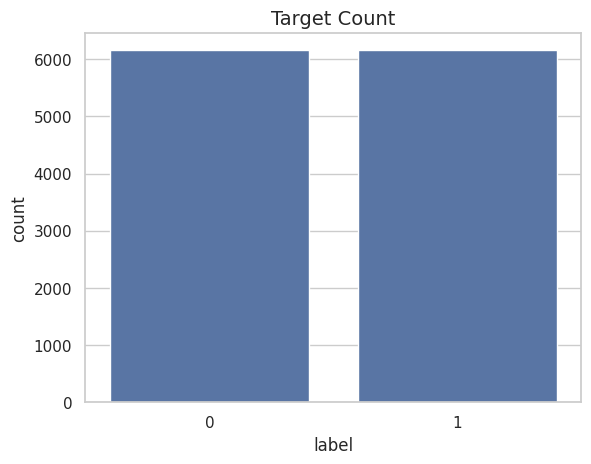

In [ ]:
label = df_news["label"].value_counts()
sns.barplot(x=label.index, y=label)
plt.title('Target Count', fontsize=14)

In [ ]:
df_news.drop_duplicates(subset=['translated'],keep='first',inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8660 entries, 2826 to 3146
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   translated  8660 non-null   object
 1   label       8660 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 203.0+ KB


In [ ]:
print('Number of 0 (Not Fake) : ', df_news["label"].value_counts()[0])
print('Number of 1 (Fake) : ', df_news["label"].value_counts()[1])

Number of 0 (Not Fake) :  5179
Number of 1 (Fake) :  3481


In [ ]:
x= df_news["translated"]
y = df_news["label"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

# LOGISTIC REGRESSION

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1295
           1       0.97      0.91      0.94       870

    accuracy                           0.95      2165
   macro avg       0.96      0.95      0.95      2165
weighted avg       0.95      0.95      0.95      2165



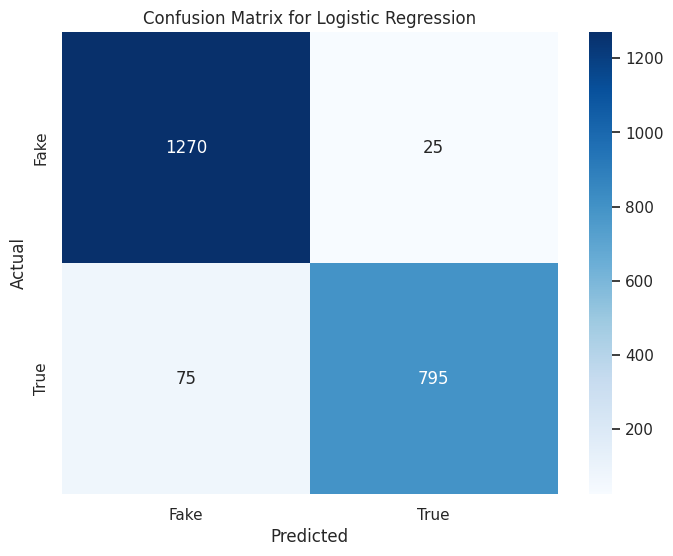

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)

pred_lr=LR.predict(xv_test)
LR.score(xv_test, y_test)

print(classification_report(y_test, pred_lr))

confusion_mat = confusion_matrix(y_test, pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

Logistic Regression AUC: 0.988383260107398


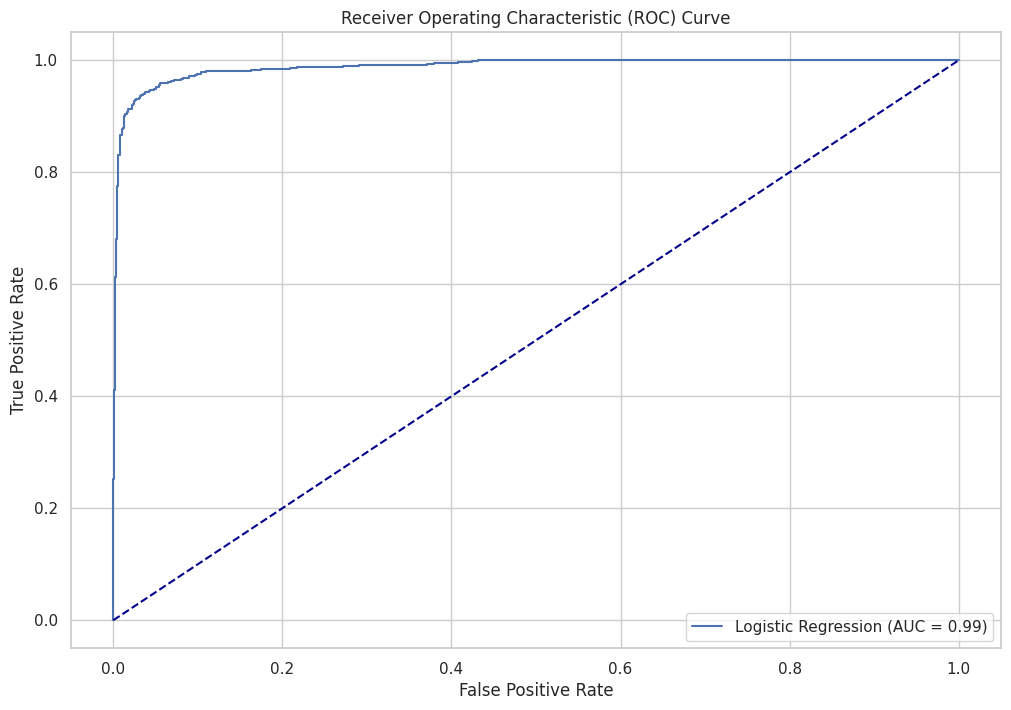

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have already trained the models and have xv_test, y_test available

# Models
models ={"Logistic Regression": LR}

plt.figure(figsize=(12, 8))

for name, model in models.items():
    probs = model.predict_proba(xv_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    print(f"{name} AUC: {auc}")
    plt.plot(fper, tper, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.savefig('roc_curves.jpg', bbox_inches='tight', transparent=True)
plt.show()


# Gradient Boosting Classifier

Accuracy: 94.18%
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1295
           1       0.95      0.90      0.93       870

    accuracy                           0.94      2165
   macro avg       0.94      0.94      0.94      2165
weighted avg       0.94      0.94      0.94      2165



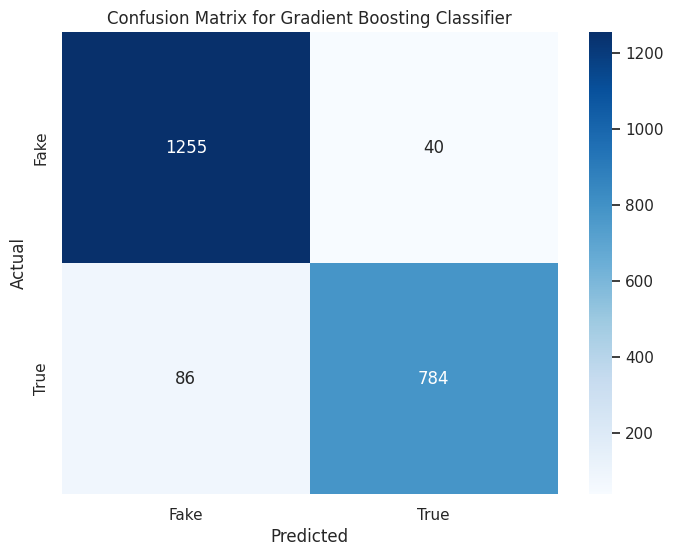

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(random_state=0)
GBC.fit(xv_train, y_train)

pred_gbc = GBC.predict(xv_test)
accuracy = GBC.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_gbc))

confusion_mat = confusion_matrix(y_test, pred_gbc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.show()

Gradient Boosting AUC: 0.9856153197532509


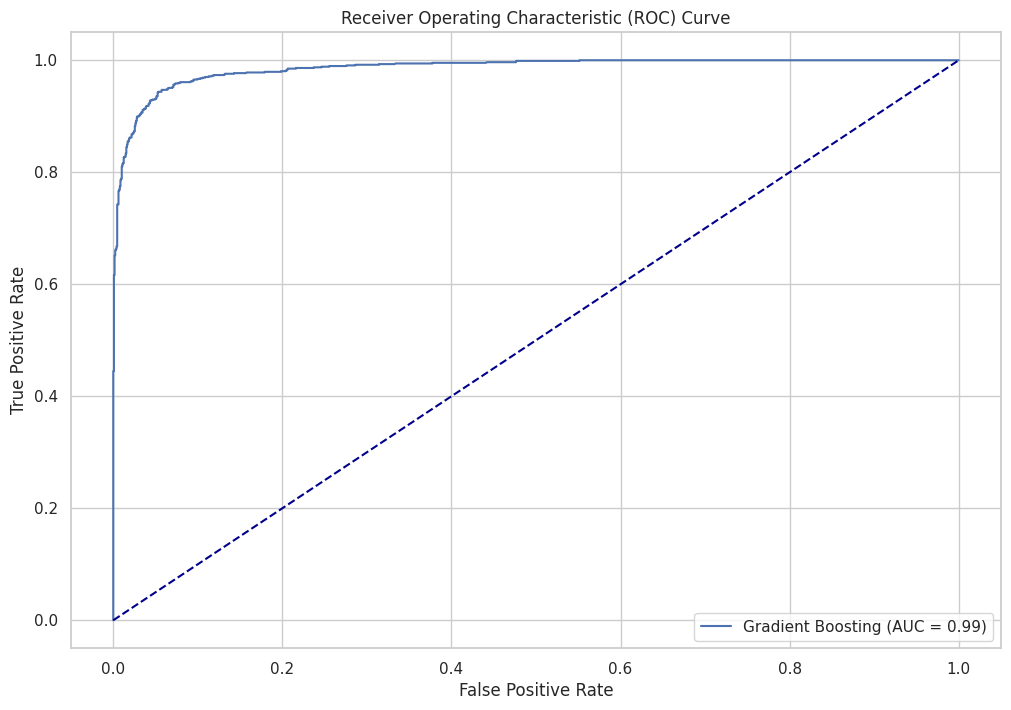

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Models
models = {

    "Gradient Boosting": GBC
  }

plt.figure(figsize=(12, 8))

for name, model in models.items():
    probs = model.predict_proba(xv_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    print(f"{name} AUC: {auc}")
    plt.plot(fper, tper, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.savefig('roc_curves.jpg', bbox_inches='tight', transparent=True)
plt.show()


# Random Forest Classfier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)

pred_rfc = RFC.predict(xv_test)
accuracy = RFC.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_rfc))

confusion_mat = confusion_matrix(y_test, pred_rfc)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have already trained the models and have xv_test, y_test available

# Models
models = {

    "Random Forest": RFC
}

plt.figure(figsize=(12, 8))

for name, model in models.items():
    probs = model.predict_proba(xv_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    print(f"{name} AUC: {auc}")
    plt.plot(fper, tper, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.savefig('roc_curves.jpg', bbox_inches='tight', transparent=True)
plt.show()


# Decision Tree Classifier

In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
DT = DecisionTreeClassifier()
DT.fit(xv_train, y_train)

pred_dt = DT.predict(xv_test)
accuracy = DT.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_dt))

confusion_mat = confusion_matrix(y_test, pred_dt)
# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have already trained the models and have xv_test, y_test available

# Models
models = {

    "Decision Tree": RFC
}

plt.figure(figsize=(12, 8))

for name, model in models.items():
    probs = model.predict_proba(xv_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test, probs)
    print(f"{name} AUC: {auc}")
    plt.plot(fper, tper, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='best')
plt.savefig('roc_curves.jpg', bbox_inches='tight', transparent=True)
plt.show()


#XGBoost Classifier

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Assuming you have already done the preprocessing and splitting
# xv_train, xv_test, y_train, y_test

# Train the XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    base_score=0.5,
    booster='gbtree',
    n_estimators=1000,
    early_stopping_rounds=50,
    objective='binary:logistic',
    max_depth=3,
    learning_rate=0.01
)

xgb_model.fit(xv_train, y_train,
              eval_set=[(xv_train, y_train), (xv_test, y_test)],
              verbose=100)

# Make predictions
pred_xgb = xgb_model.predict(xv_test)

# Evaluate the model
accuracy = xgb_model.score(xv_test, y_test) * 100
print(f"Accuracy: {accuracy:.2f}%")
print(classification_report(y_test, pred_xgb))

# Plot Confusion Matrix
confusion_mat = confusion_matrix(y_test, pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# # Train the Random Forest Classifier
# rfc_model = RandomForestClassifier(
#     n_estimators=1000,
#     max_depth=10,
#     random_state=0
# )

# rfc_model.fit(xv_train, y_train)

# # Make predictions
# pred_rfc = rfc_model.predict(xv_test)

# # Evaluate the model
# accuracy = rfc_model.score(xv_test, y_test) * 100
# print(f"Accuracy: {accuracy:.2f}%")
# print(classification_report(y_test, pred_rfc))

# # Plot Confusion Matrix
# confusion_mat = confusion_matrix(y_test, pred_rfc)
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for Random Forest Classifier')
# plt.show()
